Author: Carlos Roberto de Melo

Date: 06/03/2020

Obj: Subtrair os arcos gravitacionais da imagem original com a galáxia e então interpolar sobre a região

In [16]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from mpdaf.obj import Image, WCS
from mpdaf.obj import deg2sexa, sexa2deg
from scipy import interpolate

[INFO] 750 x 750 Image (/home/carlos/Desktop/ESO325 HST Data Reduction/Data/F814W_centerized.fits)
[INFO] .data(750 x 750) (no unit), no noise
[INFO] center:(-38:10:33.4195,13:43:33.2207) size:(30.000",30.000") step:(0.040",0.040") rot:-0.0 deg frame:FK5
[INFO] 750 x 750 Image (/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Arcs Filter.fits)
[INFO] .data(750 x 750) (no unit), no noise
[INFO] center:(-38:10:33.4195,13:43:33.2207) size:(30.000",30.000") step:(0.040",0.040") rot:0.0 deg frame:FK5


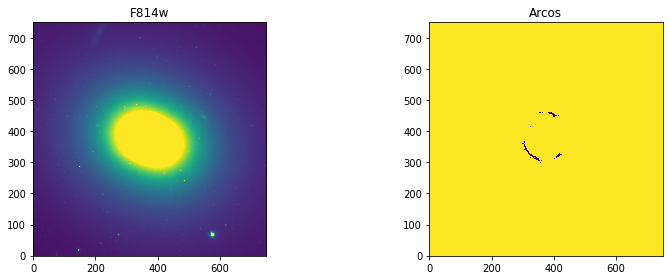

In [2]:
#Abrindo a imagem com a galáxia e o filtro com os arcos

f814w = Image('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/F814W_centerized.fits', ext=1)
filtro = Image('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Arcs Filter.fits', ext=1)

f814w.info()
filtro.info()

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

f814w.plot(ax=ax1, vmin=0, vmax=1, title='F814w')
filtro.plot(ax=ax2, vmin=0, vmax=1, title='Arcos')

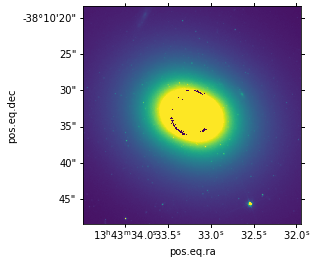

In [3]:
#Aplicando o filtro
f814w_filtered = f814w*filtro
f814w_filtered.plot(vmin=0, vmax=1, use_wcs=True)
plt.savefig('/home/carlos/Desktop/ESO325 HST Data Reduction/Images/F814 Filtrada.png', fmt='png', dpi=1200)

In [4]:
#Agora para cada posição dos arcos vamos atribuir na imagem um nan
f814w_filtered.data.data[f814w_filtered.data.data == 0] = np.nan
img = f814w_filtered.data.data #Apenas uma mudança de variáveis para economizar linhas

In [5]:
#Gerando o grid sobre o qual será armazenada a nova imagem interpolada
x = np.arange(0, img.shape[1])
y = np.arange(0, img.shape[0])

#mask invalid values
img = np.ma.masked_invalid(img)
xx, yy = np.meshgrid(x, y)

#get only the valid values
x1 = xx[~img.mask]
y1 = yy[~img.mask]
newarr = img[~img.mask]

#Efetivamente realizando a interpolação sobre os arcos
GD1 = interpolate.griddata((x1, y1), newarr.ravel(),
                          (xx, yy),
                             method='cubic')

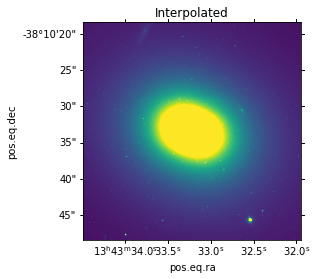

In [6]:
#Retomando a interplação para o arquivo original. Isso torna o processo de salvar a imagem compatível com o mpdaf
f814w_filtered.data.data[:] = GD1

#Plotando a imagem interpolada
f814w_filtered.plot(vmin=0, vmax=1, use_wcs=True, title='Interpolated')
plt.savefig('/home/carlos/Desktop/ESO325 HST Data Reduction/Images/F814w interpolate.png', fmt='png', dpi=1200)

#Salvando a Imagem interpolada em formato fits
f814w_filtered.write('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/F814w Interpolated.fits')

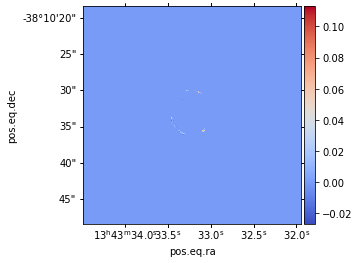

In [7]:
#Agora vamos abrir a imagem original e a interpolada para termos uma ideia do resíduo
original = Image('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/F814W_centerized.fits', ext=1)
interpolada = Image('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/F814w Interpolated.fits', ext=1)

residuo = original - interpolada
residuo.plot(cmap='coolwarm',colorbar='v', use_wcs=True,vmin = np.min(residuo.data.data),vmax=np.max(residuo.data.data))
plt.savefig('/home/carlos/Desktop/ESO325 HST Data Reduction/Images/Residuo.png', fmt='png', dpi=1200)